# Визуализация результатов симуляций работы кэша

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Локализация

In [2]:
l10n = {
    'en': {
        'Peaks': {
            '_Title': 'Cache misses, count',
            'fixed_cache_misses_count': 'Fixed time to live',
            'random_cache_misses_count': 'Pseudorandom time to live',
        },
        'CacheLoss': {
            '_Title': 'Cache keys loss, %',
            'ShardsBefore': 'Servers count before changing',
            'ShardsAfter': 'Servers count after changing',
            'LostKeysPercent': 'Cache loss percent',
        },
    },
    'ru': {
        'Peaks': {
            '_Title': 'Промахи кэша, шт.',
            'fixed_cache_misses_count': 'Фиксированное время жизни',
            'random_cache_misses_count': 'Псевдослучайное время жизни',

        },
        'CacheLoss': {
            '_Title': 'Потери накопленного кэша, %',
            'ShardsBefore': 'Серверов до изменения',
            'ShardsAfter': 'Серверов после изменения',
            'LostKeysPercent': 'Процент потери кэша',
        },
    },
}

labels = l10n['en']

## График затухания пиков нагрузки при холодном старте

In [3]:
df_peak_fixed = pd.read_csv('data/cold_start_fixed.csv', sep='\t')
df_peak_fixed = df_peak_fixed.rename(index=str, columns={'period_cache_misses': 'fixed_cache_misses_count'})
df_peak_fixed.head()

,time,miss_percent,fixed_cache_misses_count,period_requests
0,0,79.36,3968,5000
1,1,47.10,2355,5000
2,2,29.12,1456,5000
3,3,18.22,911,5000
4,4,10.46,523,5000


In [4]:
df_peak_random = pd.read_csv('data/cold_start_random.csv', sep='\t')
df_peak_random = df_peak_random.rename(index=str, columns={'period_cache_misses': 'random_cache_misses_count'})
df_peak_random.head()

,time,miss_percent,random_cache_misses_count,period_requests
0,0,79.36,3968,5000
1,1,47.10,2355,5000
2,2,29.12,1456,5000
3,3,18.22,911,5000
4,4,10.46,523,5000


In [5]:
peak_labels = labels['Peaks']

df_peak_combined = df_peak_fixed.merge(df_peak_random, on='time')
df_peak_combined.rename(columns=peak_labels, inplace=True)
df_peak_combined.head()

,time,miss_percent_x,Fixed time to live,period_requests_x,miss_percent_y,Pseudorandom time to live,period_requests_y
0,0,79.36,3968,5000,79.36,3968,5000
1,1,47.10,2355,5000,47.10,2355,5000
2,2,29.12,1456,5000,29.12,1456,5000
3,3,18.22,911,5000,18.22,911,5000
4,4,10.46,523,5000,10.46,523,5000


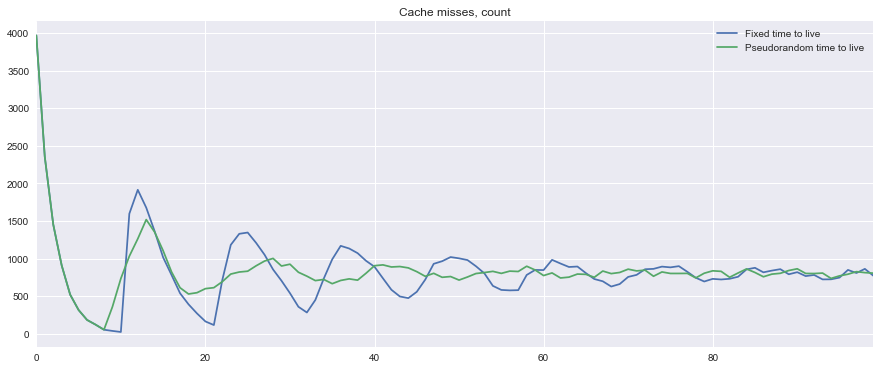

In [6]:
columns_to_show = [peak_labels['fixed_cache_misses_count'], peak_labels['random_cache_misses_count']]
df_peak_combined[columns_to_show].plot(legend=True, figsize=(15, 6), title=peak_labels['_Title'])

plt.show()

## Потери накопленного кэша при решардинге

In [7]:
df_modulo_loss = pd.read_csv('data/modulo_resharding_1-32.csv', sep='\t')
df_modulo_loss['LostKeysPercent'] = df_modulo_loss['LostKeysPercent'].map(lambda x: x.replace('%', '')).astype('float')
df_modulo_loss.head()

,ShardsBefore,ShardsAfter,LostKeysPercent
0,1,1,0.00
1,1,2,50.00
2,1,3,66.67
3,1,4,75.00
4,1,5,79.99


In [8]:
loss_labels = labels['CacheLoss']

filter_modulo_loss = (df_modulo_loss['ShardsBefore'] <= 16) & (df_modulo_loss['ShardsAfter'] <= 16)
df_modulo_loss_to_show = df_modulo_loss[filter_modulo_loss] \
    .rename(str, loss_labels) \
    .pivot(loss_labels['ShardsBefore'], loss_labels['ShardsAfter'], loss_labels['LostKeysPercent'])
df_modulo_loss_to_show.head()

Servers count after changing,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Servers count before changing,,,,,,,,,,,,,,,,
1,0.00,50.00,66.67,75.00,79.99,83.35,85.68,87.50,88.85,89.97,90.89,91.65,92.33,92.86,93.34,93.74
2,50.00,0.00,66.65,50.00,80.00,66.65,85.73,75.00,88.86,80.00,90.88,83.29,92.33,85.73,93.34,87.48
3,66.67,66.65,0.00,74.97,80.04,50.00,85.74,87.49,66.64,90.03,90.89,74.97,92.34,92.86,80.04,93.72
4,75.00,50.00,74.97,0.00,80.03,66.64,85.71,50.00,88.88,80.03,90.88,66.64,92.30,85.71,93.36,74.95
5,79.99,80.00,80.04,80.03,0.00,83.35,85.72,87.53,88.86,50.05,90.91,91.68,92.32,92.87,66.70,93.77


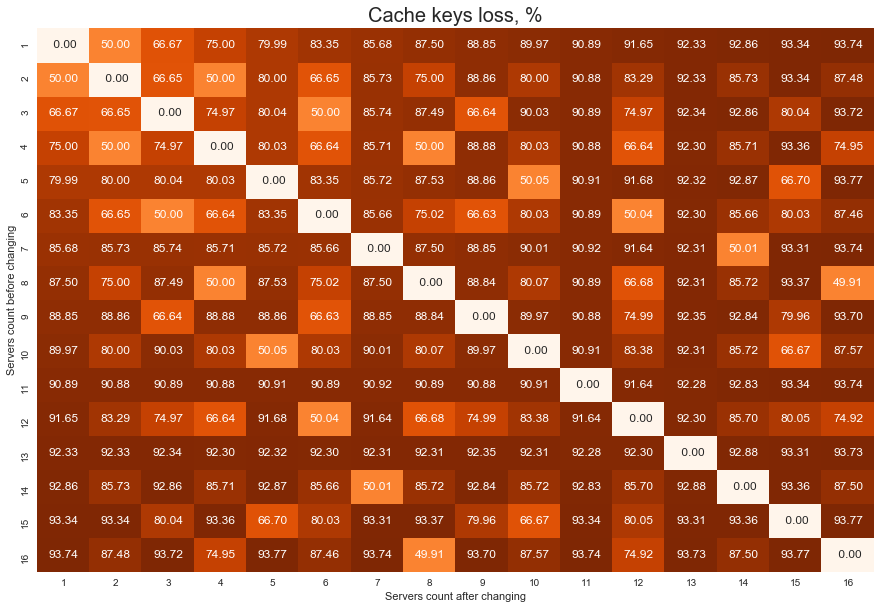

In [9]:
plt.figure(figsize=(15, 10))
plt.title(loss_labels['_Title'], fontdict={'fontsize': 20})
sns.heatmap(df_modulo_loss_to_show, cmap='Oranges', annot=True, fmt="5.2f", cbar=False)
plt.show()